# Import thư viện

In [67]:
# Thư viện cơ bản
import pandas as pd
import numpy as np


# Thư viện vẽ biểu đồ
import matplotlib.pyplot as plt
import seaborn as sns

# Bỏ qua các cảnh báo
import warnings
warnings.filterwarnings('ignore')

# Thư viện tiền xử lý dữ liệu
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, label_binarize, RobustScaler
from imblearn.over_sampling import SMOTE
from sklearn.multiclass import OneVsRestClassifier

# Thư viện mô hình
from sklearn.tree import DecisionTreeClassifier, plot_tree

# Thư viện đánh giá mô hình
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, roc_curve, auc, confusion_matrix, precision_recall_curve, f1_score, make_scorer, recall_score, precision_score

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [68]:
train.head()

,Id,Product_Info_1,Product_Info_2,Product_Info_3,Product_Info_4,Product_Info_5,Product_Info_6,Product_Info_7,Ins_Age,Ht,...,Medical_Keyword_40,Medical_Keyword_41,Medical_Keyword_42,Medical_Keyword_43,Medical_Keyword_44,Medical_Keyword_45,Medical_Keyword_46,Medical_Keyword_47,Medical_Keyword_48,Response
0,2,1,D3,10,0.076923,2,1,1,0.641791,0.581818,...,0,0,0,0,0,0,0,0,0,8
1,5,1,A1,26,0.076923,2,3,1,0.059701,0.600000,...,0,0,0,0,0,0,0,0,0,4
2,6,1,E1,26,0.076923,2,3,1,0.029851,0.745455,...,0,0,0,0,0,0,0,0,0,8
3,7,1,D4,10,0.487179,2,3,1,0.164179,0.672727,...,0,0,0,0,0,0,0,0,0,8
4,8,1,D2,26,0.230769,2,3,1,0.417910,0.654545,...,0,0,0,0,0,0,0,0,0,8


In [69]:
# Tập train chiếm 75% dữ liệu
train.shape

(59381, 128)

In [70]:
test.head()

,Id,Product_Info_1,Product_Info_2,Product_Info_3,Product_Info_4,Product_Info_5,Product_Info_6,Product_Info_7,Ins_Age,Ht,...,Medical_Keyword_39,Medical_Keyword_40,Medical_Keyword_41,Medical_Keyword_42,Medical_Keyword_43,Medical_Keyword_44,Medical_Keyword_45,Medical_Keyword_46,Medical_Keyword_47,Medical_Keyword_48
0,1,1,D3,26,0.487179,2,3,1,0.611940,0.781818,...,0,0,0,0,0,0,0,0,0,0
1,3,1,A2,26,0.076923,2,3,1,0.626866,0.727273,...,0,0,0,0,0,0,0,0,0,0
2,4,1,D3,26,0.144667,2,3,1,0.582090,0.709091,...,0,0,0,0,0,0,0,0,0,0
3,9,1,A1,26,0.151709,2,1,1,0.522388,0.654545,...,0,0,0,0,0,0,0,0,1,1
4,12,1,A1,26,0.076923,2,3,1,0.298507,0.672727,...,0,0,0,0,0,0,0,0,0,0


In [71]:
# Tập test chiếm 25% dữ liệu
test.shape

(19765, 127)

- Tổng số dòng của dữ liệu: 79146
- Tổng số cột của dữ liệu: 128

# Tiền xử lý tập train

In [7]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,59381.0,39507.211515,22815.883089,2.0,19780.000000,39487.000000,59211.000000,79146.0
Product_Info_1,59381.0,1.026355,0.160191,1.0,1.000000,1.000000,1.000000,2.0
Product_Info_3,59381.0,24.415655,5.072885,1.0,26.000000,26.000000,26.000000,38.0
Product_Info_4,59381.0,0.328952,0.282562,0.0,0.076923,0.230769,0.487179,1.0
Product_Info_5,59381.0,2.006955,0.083107,2.0,2.000000,2.000000,2.000000,3.0
...,...,...,...,...,...,...,...,...
Medical_Keyword_45,59381.0,0.013691,0.116207,0.0,0.000000,0.000000,0.000000,1.0
Medical_Keyword_46,59381.0,0.008488,0.091737,0.0,0.000000,0.000000,0.000000,1.0
Medical_Keyword_47,59381.0,0.019905,0.139676,0.0,0.000000,0.000000,0.000000,1.0
Medical_Keyword_48,59381.0,0.054496,0.226995,0.0,0.000000,0.000000,0.000000,1.0


In [8]:
train['Response'].value_counts()

Response
8    19489
6    11233
7     8027
2     6552
1     6207
5     5432
4     1428
3     1013
Name: count, dtype: int64

In [9]:
train['Response'].value_counts() / len(train) * 100

Response
8    32.820262
6    18.916825
7    13.517792
2    11.033832
1    10.452838
5     9.147707
4     2.404810
3     1.705933
Name: count, dtype: float64

Text(0.5, 1.0, 'Nhãn trước khi gộp')

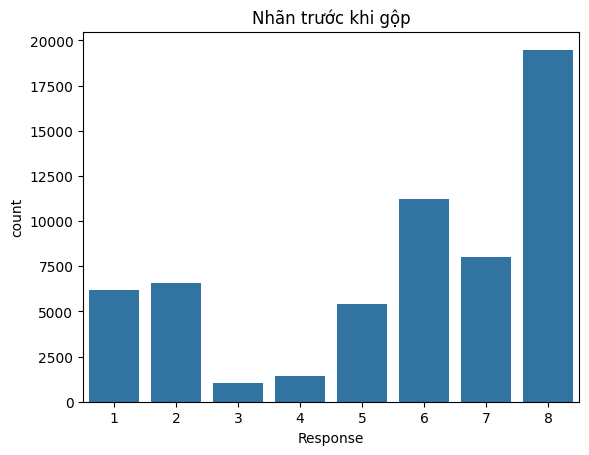

In [10]:
# Biểu đồ phân phối nhãn
sns.countplot(x=train['Response'])
plt.title("Nhãn trước khi gộp")
# Nhãn phân phối khá lệch

In [11]:
# Gộp nhãn mới như sau:
# Rủi ro thấp: 1, 2, 3 = 1
# Rủi ro trung bình: 4, 5, 6 = 2
# Rủi ro cao: 7, 8 = 3
def map_response(x):
    if x in [1, 2, 3]:
        return 1
    elif x in [4, 5, 6]:
        return 2
    else:
        return 3
train['Response'] = train['Response'].map(map_response)

In [12]:
train['Response'].value_counts()

Response
3    27516
2    18093
1    13772
Name: count, dtype: int64

In [13]:
train['Response'].value_counts() / len(train) * 100

Response
3    46.338054
2    30.469342
1    23.192604
Name: count, dtype: float64

Text(0.5, 1.0, 'Nhãn sau khi gộp')

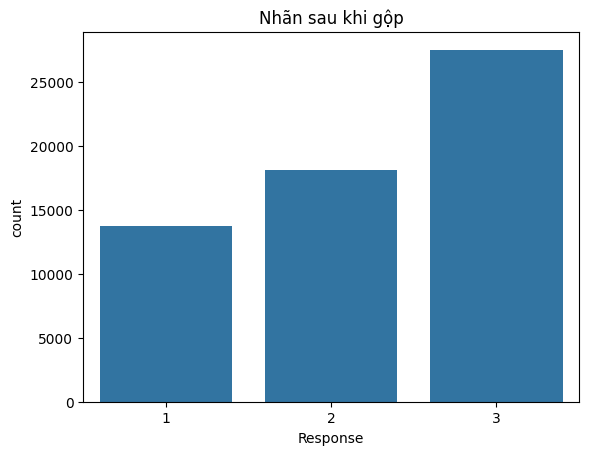

In [14]:
# Nhãn đã được phân phối lại
sns.countplot(x = train['Response'])
plt.title("Nhãn sau khi gộp")

In [15]:
le = LabelEncoder()
# Chuyển cột định tính thành định lượng
train['Product_Info_2'] = le.fit_transform(train['Product_Info_2'])

In [16]:
# Drop cột không cần thiết
train.drop(columns=['Id'], inplace=True)

In [17]:
# Xem các cột null trong tập train
train_null_cols = train.isnull().sum()[train.isnull().sum() > 0]
train_null_cols

Employment_Info_1         19
Employment_Info_4       6779
Employment_Info_6      10854
Insurance_History_5    25396
Family_Hist_2          28656
Family_Hist_3          34241
Family_Hist_4          19184
Family_Hist_5          41811
Medical_History_1       8889
Medical_History_10     58824
Medical_History_15     44596
Medical_History_24     55580
Medical_History_32     58274
dtype: int64

In [18]:
# Xem tỉ lệ các cột null trong tập train
train_null_cols / len(train) * 100

Employment_Info_1       0.031997
Employment_Info_4      11.416110
Employment_Info_6      18.278574
Insurance_History_5    42.767889
Family_Hist_2          48.257860
Family_Hist_3          57.663226
Family_Hist_4          32.306630
Family_Hist_5          70.411411
Medical_History_1      14.969435
Medical_History_10     99.061990
Medical_History_15     75.101463
Medical_History_24     93.598963
Medical_History_32     98.135767
dtype: float64

In [19]:
# Drop tất cả cột có tỉ lệ null >= 50%
train = train.loc[:, train.isnull().mean() < 0.5]

In [20]:
# Xem tỉ lệ null của các cột còn lại
train.isnull().sum()[train.isnull().sum() > 0] / len(train) * 100

Employment_Info_1       0.031997
Employment_Info_4      11.416110
Employment_Info_6      18.278574
Insurance_History_5    42.767889
Family_Hist_2          48.257860
Family_Hist_4          32.306630
Medical_History_1      14.969435
dtype: float64

In [21]:
# Fill null với trung vị theo nhãn
for cols in train.columns:
    if train[cols].isnull().sum() > 0 and cols != 'Response':
        train[cols] = train.groupby('Response')[cols].transform(lambda x: x.fillna(x.median()))

# Tiền xử lý tập test

In [22]:
test.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,19765.0,39772.653883,22942.157493,1.0,19792.000000,39898.000000,59758.000000,79129.0
Product_Info_1,19765.0,1.024994,0.156110,1.0,1.000000,1.000000,1.000000,2.0
Product_Info_3,19765.0,24.321730,5.184879,2.0,26.000000,26.000000,26.000000,37.0
Product_Info_4,19765.0,0.324381,0.279439,0.0,0.076923,0.230769,0.487179,1.0
Product_Info_5,19765.0,2.006527,0.080526,2.0,2.000000,2.000000,2.000000,3.0
...,...,...,...,...,...,...,...,...
Medical_Keyword_44,19765.0,0.008247,0.090440,0.0,0.000000,0.000000,0.000000,1.0
Medical_Keyword_45,19765.0,0.013559,0.115655,0.0,0.000000,0.000000,0.000000,1.0
Medical_Keyword_46,19765.0,0.008601,0.092345,0.0,0.000000,0.000000,0.000000,1.0
Medical_Keyword_47,19765.0,0.018315,0.134092,0.0,0.000000,0.000000,0.000000,1.0


In [23]:
# Chuyển cột định tính thành định lượng với thông tin đã huấn luyện từ tập train
test['Product_Info_2'] = le.transform(test['Product_Info_2'])

In [24]:
# Drop cột không cần thiết
test.drop(columns=['Id'], inplace=True)

In [25]:
# Xem các cột null trong tập test
test_null_cols = test.isnull().sum()[test.isnull().sum() > 0]
test_null_cols

Employment_Info_1          3
Employment_Info_4       2137
Employment_Info_6       3787
Insurance_History_5     8105
Family_Hist_2           9880
Family_Hist_3          11064
Family_Hist_4           6677
Family_Hist_5          13624
Medical_History_1       2972
Medical_History_10     19564
Medical_History_15     14864
Medical_History_24     18585
Medical_History_32     19414
dtype: int64

In [26]:
# Xem tỉ lệ các cột null trong tập test
test_null_cols / len(test) * 100

Employment_Info_1       0.015178
Employment_Info_4      10.812041
Employment_Info_6      19.160132
Insurance_History_5    41.006830
Family_Hist_2          49.987351
Family_Hist_3          55.977738
Family_Hist_4          33.781938
Family_Hist_5          68.929927
Medical_History_1      15.036681
Medical_History_10     98.983051
Medical_History_15     75.203643
Medical_History_24     94.029851
Medical_History_32     98.224134
dtype: float64

In [27]:
# Drop tất cả cột có tỉ lệ null >= 50%
test = test.loc[:, test.isnull().mean() < 0.5]

In [28]:
# Xem tỉ lệ null của các cột còn lại
test.isnull().sum()[test.isnull().sum() > 0] / len(test) * 100

Employment_Info_1       0.015178
Employment_Info_4      10.812041
Employment_Info_6      19.160132
Insurance_History_5    41.006830
Family_Hist_2          49.987351
Family_Hist_4          33.781938
Medical_History_1      15.036681
dtype: float64

In [29]:
# Lấy median theo nhãn từ train
# Vì file test không có nhãn, nên phải lấy median của từng cột theo file train, rồi fill null cho file test
fill_values = train.groupby('Response').median()

In [30]:
# Fill theo nhãn phổ biến nhất (nhãn 2)
default_class = 2

# Fill null với trung vị theo nhãn
for cols in test.columns:
    if test[cols].isnull().sum() > 0:
        test[cols] = test[cols].fillna(fill_values.loc[default_class, cols])

# Chia Train, Validation

- Lí do chia tập dữ liệu train thành train và valid là do tập test không có nhãn
- => phải huấn luyện và kiểm tra trên train và valid sau đó đưa dự đoán vào test

In [31]:
# Tách dữ liệu: X - thuộc tính | y - nhãn
X = train.drop(['Response'], axis=1)
y = train['Response']

In [32]:
# Sau khi chia dữ liệu: Train - 60%, Validation - 15%, Test - 25%
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=1/5, random_state=42, stratify=y)

# Khi này X_test chính là tập test
X_test = test

# Shape của 3 tập
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape

((47504, 120), (47504,), (11877, 120), (11877,), (19765, 120))

Text(0.5, 1.0, 'Nhãn của tập train')

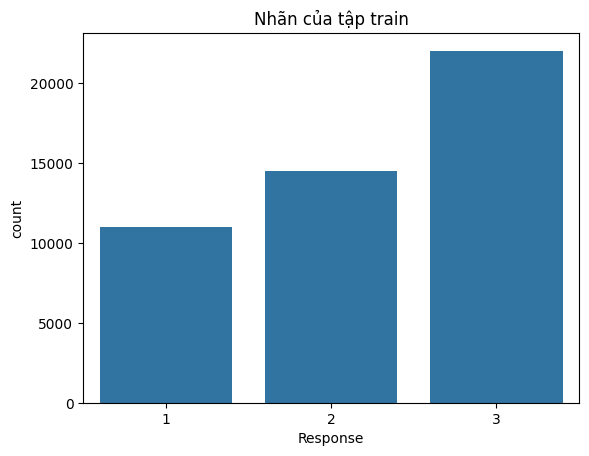

In [33]:
sns.countplot(x=y_train)
plt.title("Nhãn của tập train")

In [34]:
# Phần trăm nhãn của tập train
y_train.value_counts() / len(y_train) * 100

Response
3    46.339256
2    30.469013
1    23.191731
Name: count, dtype: float64

Text(0.5, 1.0, 'Nhãn của tập validation')

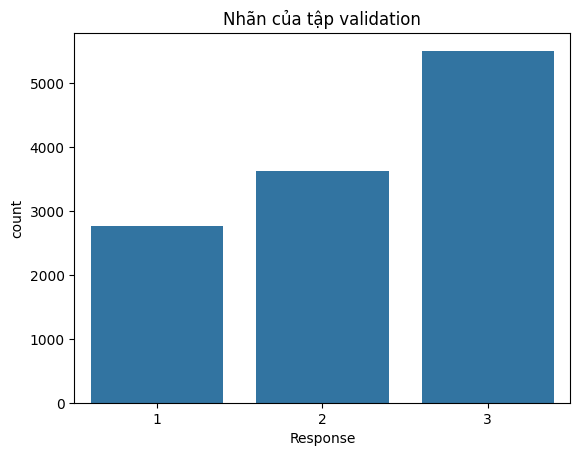

In [35]:
sns.countplot(x=y_val)
plt.title("Nhãn của tập validation")

In [36]:
# Phần trăm nhãn của tập validation
y_val.value_counts() / len(y_val) * 100

Response
3    46.333249
2    30.470658
1    23.196093
Name: count, dtype: float64

# Chạy mô hình

- Lựa chọn mô hình Decision Tree 
## Lí do:
+ Dễ trực quan hóa bằng sơ đồ cây => dễ giải thích
+ Không sợ ngoại lai vì chia nhánh dựa trên độ hỗn loạn và độ tăng thông tin
+ Chống overfitting dễ dàng bằng cách điều chỉnh độ sâu tối đa, số lá tối thiểu, ...

In [37]:
clf_dt = DecisionTreeClassifier(random_state=42, class_weight='balanced')

# Huấn luyện mô hình
clf_dt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', random_state=42)

In [38]:
# Dự đoán trên tập validation
y_pred = clf_dt.predict(X_val)

In [39]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           1       0.88      0.88      0.88      2755
           2       0.87      0.88      0.88      3619
           3       0.92      0.92      0.92      5503

    accuracy                           0.90     11877
   macro avg       0.89      0.89      0.89     11877
weighted avg       0.90      0.90      0.90     11877



In [40]:
cross_val_score(clf_dt, X_val, y_val)

array([0.88510101, 0.87247475, 0.89052632, 0.88589474, 0.87705263])

Text(0.5, 1.0, 'Ma trận nhầm lẫn trước khi tối ưu mô hình')

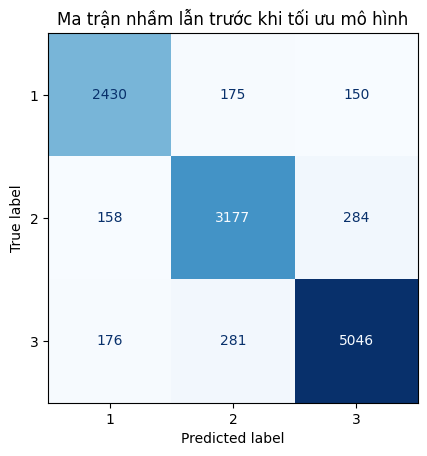

In [41]:
# Ma trận nhầm lẫn
ConfusionMatrixDisplay.from_estimator(clf_dt, X_val, y_val, cmap='Blues', colorbar=False)
plt.xticks([0, 1, 2], [1, 2, 3])
plt.yticks([0, 1, 2], [1, 2, 3])
plt.title("Ma trận nhầm lẫn trước khi tối ưu mô hình")

# Tối ưu mô hình

## Dùng GridSearchCV để tìm parameter
Lí do:
- Tối ưu toàn diện nhiều yếu tố: max_depth, min_samples_split, min_samples_leaf, max_leaf_nodes, ...
- Các tham số trên trực tiếp ảnh hưởng đến độ sâu và độ phức tạp => tránh overfit/underfit
- Có thể kết hợp cross-validation
- Hợp với dữ liệu nhiều feature

In [93]:
param_grid = {
    'criterion': ['gini','entropy'],                       # Tiêu chí chia nhánh
    'max_depth': [4, 6, 8],                                # Giới hạn độ sâu
    'min_samples_split': [50, 100, 150],                   # Số mẫu tối thiểu để split
    'min_samples_leaf': [40, 50],                          # Số mẫu tối thiểu trong mỗi lá
    'class_weight': [None, 'balanced']                     # Cân bằng nhãn trong loss
}

In [94]:
grid_search = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_grid=param_grid,
    scoring='recall_weighted',
    cv=5,                                                  # Kiểm tra chéo 5 lần
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'class_weight': [None, 'balanced'],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 6, 8], 'min_samples_leaf': [40, 50],
                         'min_samples_split': [50, 100, 150]},
             scoring='recall_weighted', verbose=1)

In [95]:
# Cây đẹp nhất
best_clf_dt = grid_search.best_estimator_

In [96]:
y_best_pred = best_clf_dt.predict(X_val)

In [97]:
print(classification_report(y_val, y_best_pred))

              precision    recall  f1-score   support

           1       0.98      0.83      0.90      2755
           2       0.86      0.91      0.88      3619
           3       0.91      0.94      0.93      5503

    accuracy                           0.91     11877
   macro avg       0.92      0.90      0.90     11877
weighted avg       0.91      0.91      0.91     11877



In [98]:
cross_val_score(best_clf_dt, X_val, y_val)

array([0.89183502, 0.89351852, 0.89810526, 0.89852632, 0.89726316])

([<matplotlib.axis.YTick at 0x71781ef8d6a0>,
 [Text(0, 0, '1'), Text(0, 1, '2'), Text(0, 2, '3')])

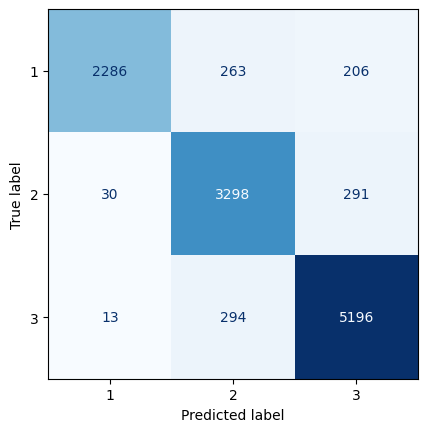

In [99]:
cm_best = confusion_matrix(y_val, y_best_pred)
disp = ConfusionMatrixDisplay(cm_best)
disp.plot(cmap='Blues', colorbar=False)
plt.xticks([0, 1, 2], [1, 2, 3])
plt.yticks([0, 1, 2], [1, 2, 3])

In [100]:
y_val_bin = label_binarize(y_val, classes=[1, 2, 3])
# Chuyển nhãn y_val ([1, 2, 3]) thành dạng nhị phân (one-hot), ví dụ:
# [1, 2, 3] → [[1,0,0], [0,1,0], [0,0,1]].

n_classes = y_val_bin.shape[1]
# Lấy số lớp phân loại (ở đây là 3 lớp).

In [101]:
y_score = best_clf_dt.predict_proba(X_val)
# Trả về xác suất cho mỗi mẫu trong X_val

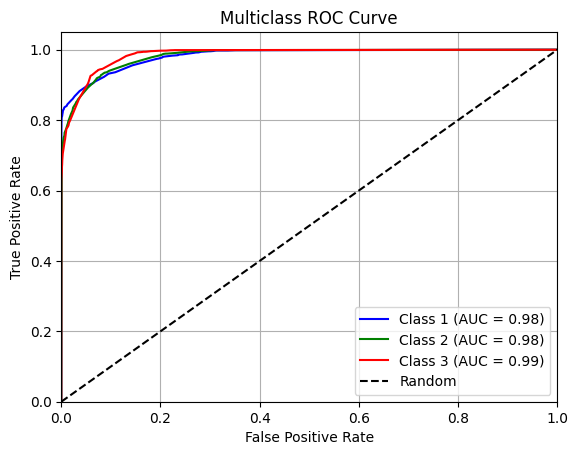

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Vẽ
plt.figure()
colors = ['blue', 'green', 'red']
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i],
             label=f'Class {i + 1} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Mô hình có khả năng phân loại rất tốt (AUC đều trên 0.9)!!

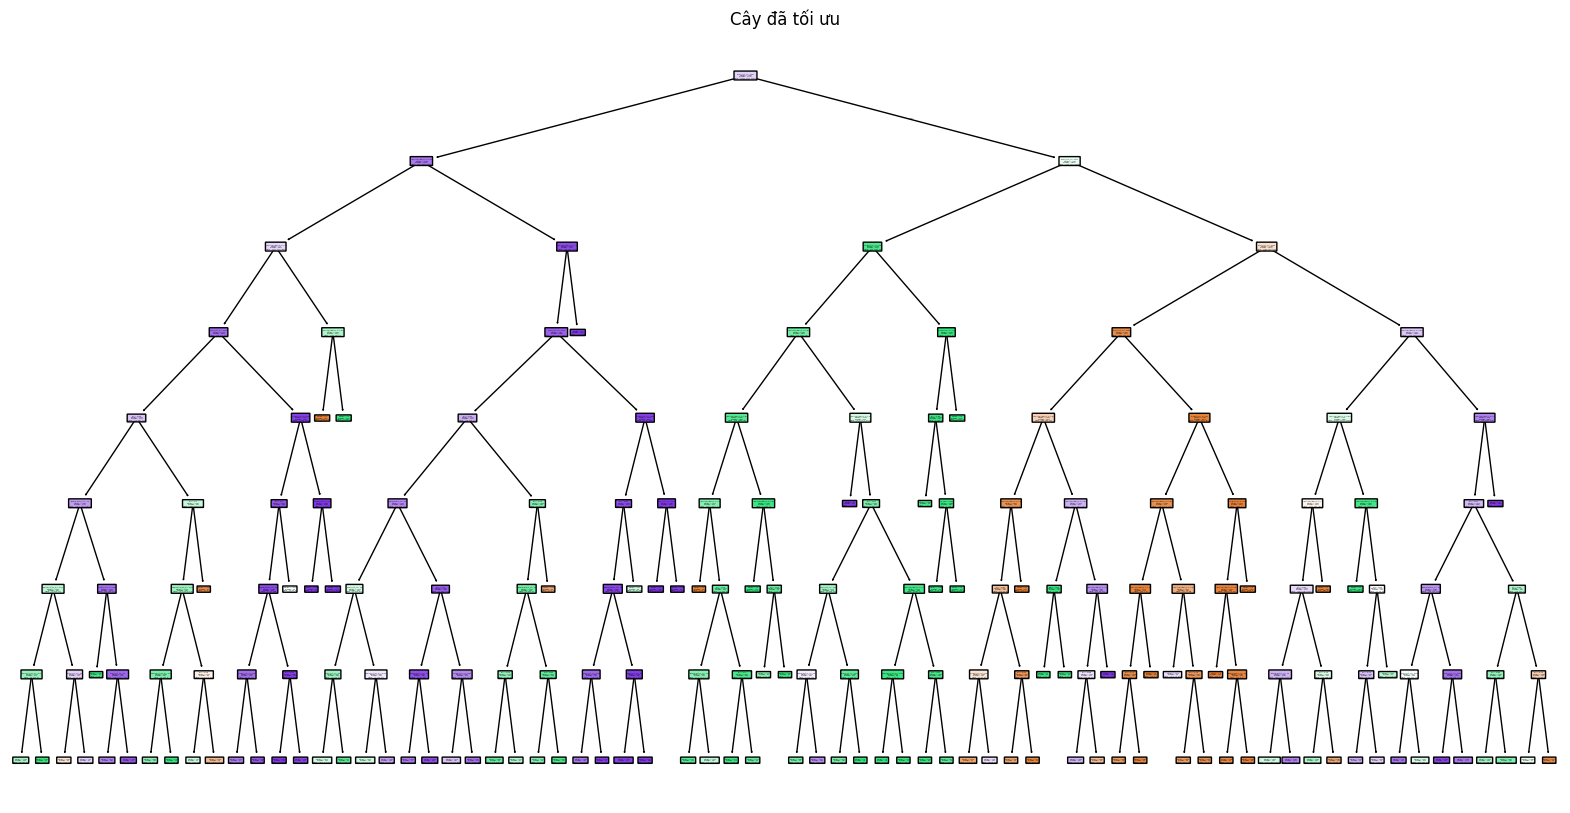

In [103]:
plt.figure(figsize=(20, 10))
plot_tree(best_clf_dt, feature_names=train.columns, class_names=['1', '2', '3'], filled=True, rounded=True)
plt.title("Cây đã tối ưu")
plt.show()

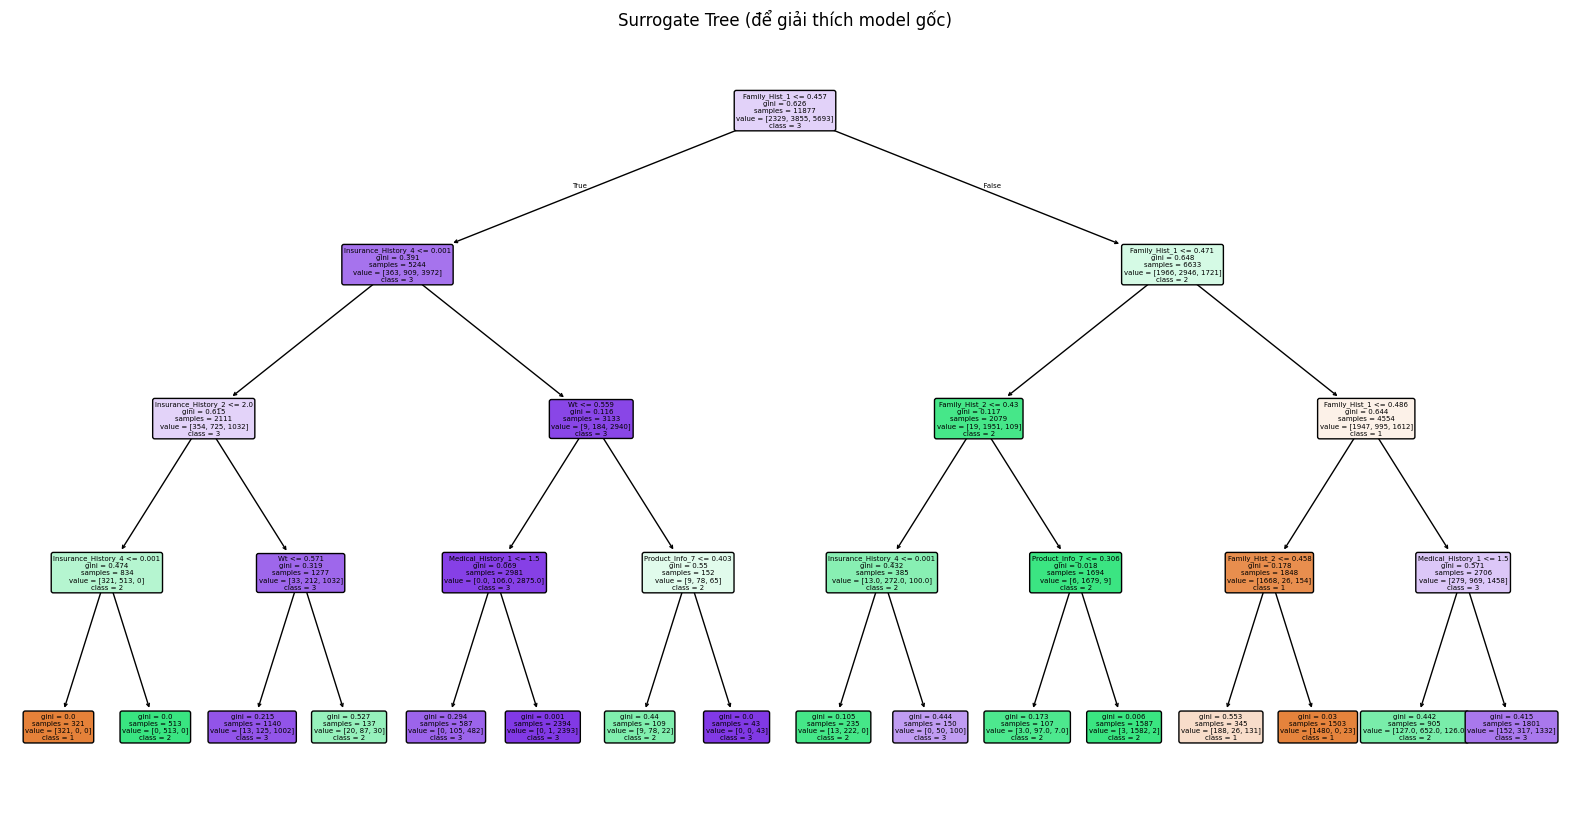

In [105]:
# Vẽ 1 cây phụ nhỏ để dễ giải thích

# Dự đoán của mô hình đã được tối ưu trên tập validation
y_best_pred_main = best_clf_dt.predict(X_val)

# Huấn luyện cây phụ
surrogate = DecisionTreeClassifier(max_depth=4, random_state=0)
surrogate.fit(X_val, y_best_pred_main)

plt.figure(figsize=(20, 10))
plot_tree(surrogate, feature_names=train.columns, class_names=['1', '2', '3'], filled=True, rounded=True, fontsize=5)
plt.title("Surrogate Tree (để giải thích model gốc)")
plt.show()

In [106]:
print(classification_report(y_best_pred_main, surrogate.predict(X_val)))

              precision    recall  f1-score   support

           1       0.92      0.85      0.88      2329
           2       0.90      0.84      0.87      3855
           3       0.88      0.94      0.91      5693

    accuracy                           0.89     11877
   macro avg       0.90      0.88      0.89     11877
weighted avg       0.89      0.89      0.89     11877



Text(0.5, 1.0, 'Ma trận nhầm lẫn của cây phụ')

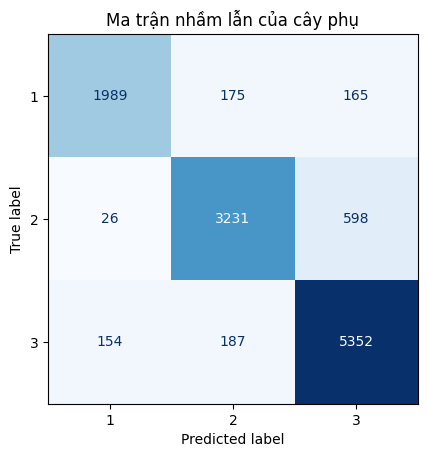

In [107]:
cm_sur = confusion_matrix(y_best_pred_main, surrogate.predict(X_val))
disp = ConfusionMatrixDisplay(cm_sur)
disp.plot(cmap='Blues', colorbar=False)
plt.xticks([0, 1, 2], [1, 2, 3])
plt.yticks([0, 1, 2], [1, 2, 3])
plt.title("Ma trận nhầm lẫn của cây phụ")

In [109]:
# Kiểm tra độ quan trọng của thuộc tính đến mô hình
def check_importance(model, feature_names):
    importances = model.feature_importances_
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)
    
    # Lọc các feature có độ quan trọng > 0
    importance_df = importance_df[importance_df['Importance'] > 0]
    
    print(importance_df)

check_importance(best_clf_dt, X_train.columns)

                Feature  Importance
33        Family_Hist_2    0.497324
28  Insurance_History_5    0.209289
29  Insurance_History_7    0.101668
27  Insurance_History_4    0.047128
10                  BMI    0.044748
7               Ins_Age    0.028128
34        Family_Hist_4    0.027333
38    Medical_History_4    0.022096
26  Insurance_History_3    0.011269
3        Product_Info_4    0.002726
31  Insurance_History_9    0.002683
16    Employment_Info_6    0.002417
35    Medical_History_1    0.002009
9                    Wt    0.000500
46   Medical_History_13    0.000370
32        Family_Hist_1    0.000133
36    Medical_History_2    0.000101
11    Employment_Info_1    0.000045
8                    Ht    0.000033


# Dự đoán nhãn cho tập test

In [110]:
# Dự đoán trên file test bằng mô hình tốt nhất
y_pred_test = best_clf_dt.predict(X_test)

In [111]:
# Tạo cột Response cho file test
test['Response'] = y_pred_test

In [112]:
# Lưu lại kết quả ra 1 file csv
test.to_csv('test_with_response.csv', index=False)